#### Modelos de clasificación con selección de características y ajuste de hiperparámetros
 Tipo de Selección utilizada de base para Clasificación : SFS-BSC
 
 Autores:
     - Galván, Hugo César
     - Boveda, Agustina
     - Koss, Pablo
     - Galván, Sebastián
     


In [339]:
import sys
assert sys.version_info >= (3, 5)
import os
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore') # Para evitar los molestos avisos.
%matplotlib inline

In [340]:
# Estandarizador (transforma las variables en z-scores)
import scipy.stats as st
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.linear_model import LogisticRegression
from xgboost.sklearn import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.metrics import roc_auc_score, classification_report, mean_squared_error, confusion_matrix, accuracy_score, precision_score, recall_score # Accuracy metrics 
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from scikitplot.metrics import plot_roc


In [341]:
from sklearn.metrics import mean_squared_error


In [342]:
import utils as ut
import pickle
# Indicamos que los tipos de datos float se muestren con 2 decimales
pd.options.display.float_format = '{:.2f}'.format

In [343]:
def balanced_accuracy(cm): # funcion para calcular la "balanced accuracy"
  sensibilidad = cm[1,1]/(cm[1,1]+cm[0,1])
  especificidad = cm[0,0]/(cm[1,0]+cm[0,0])
  return [sensibilidad, especificidad, (sensibilidad + especificidad)/2]

In [344]:
DATA_PATH = "../data/union/End"
def load_data_prep(data_path=DATA_PATH):
    csv_path = os.path.join(data_path, "dataset_final.csv")
    return pd.read_csv(csv_path)

In [345]:
df = load_data_prep()

In [346]:
df1 = df[[ 'ccbd_diameter', 'sl2l_mean_length',
 'sl2l_diameter', 'ccbd_mean_length',
 'sl2l_volume', 'tral_volume','label']]
df1.shape

(96, 7)

In [347]:
# Partición en train y test
y = df1.loc[:, df1.columns == 'label']
X = df1.loc[:, df1.columns != 'label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=99)

In [348]:
std_scale = StandardScaler() # Creamos el estandarizador para usarlo posteriormente

In [349]:
# Ajustamos el estandarizador
std_scale.fit(X_test)
std_scale.fit(X_train)

# Aplicamos el estandarizador y obtenemos la matriz de features escaleados
X_test_scaled = std_scale.transform(X_test)
X_scaled = std_scale.transform(X_train)

### Modelo de Clasificación: Regresión Logística

In [350]:
logreg = LogisticRegression()
logreg.fit(X_scaled, y_train)

LogisticRegression()

In [351]:
y_train_pred = logreg.predict(X_scaled)
y_pred = logreg.predict(X_test_scaled)
print('Accuracy: {:.2f}'.format(logreg.score(X_test_scaled, y_test)))

Accuracy: 0.90


In [352]:
import sklearn.metrics as metrics

In [353]:
y_train_pred.argmax()

2

In [354]:
train_accuracy =  metrics.accuracy_score(y_train_pred,y_train) 
test_accuracy =  metrics.accuracy_score(y_pred, y_test)
print(f'Accuracy en el train set: {train_accuracy:.2f}')
print(f'Accuracy en el test set: {test_accuracy:.2f}')


Accuracy en el train set: 0.74
Accuracy en el test set: 0.90


In [355]:
print(classification_report(y_true=y_test,y_pred=logreg.predict(X_test_scaled)))

              precision    recall  f1-score   support

           0       0.88      0.88      0.88         8
           1       0.92      0.92      0.92        12

    accuracy                           0.90        20
   macro avg       0.90      0.90      0.90        20
weighted avg       0.90      0.90      0.90        20



In [356]:
y_test_=y_test.values

In [357]:
valor2 = logreg.predict(X_test_scaled.tolist()).tolist()
valor1 = y_test.label.values.tolist()

In [358]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(valor1, valor2) 
metricas = balanced_accuracy(cm)
print('Matriz de confusion del modelo es:')
print(cm)
print('Sensibilidad del modelo es de: {}'.format(round(metricas[0],4)))  
print('Especificidad del modelo es de: {}'.format(round(metricas[1],4)))  
print('BA del modelo es de: {}'.format(round(metricas[2],4))) 

Matriz de confusion del modelo es:
[[ 7  1]
 [ 1 11]]
Sensibilidad del modelo es de: 0.9167
Especificidad del modelo es de: 0.875
BA del modelo es de: 0.8958


In [359]:
#!pip install -U --upgrade scikit-learn

In [360]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
confusion_matrix = confusion_matrix(y_test, y_pred)
print(confusion_matrix)

[[ 7  1]
 [ 1 11]]


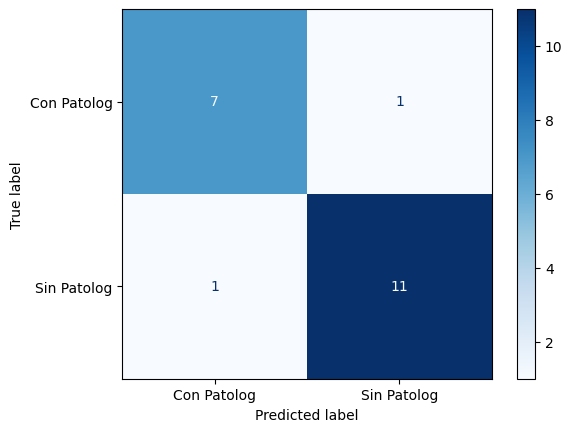

In [361]:
class_names = ['Con Patolog', 'Sin Patolog']
ConfusionMatrixDisplay.from_estimator(logreg, X_test_scaled, y_test, display_labels=class_names, cmap=plt.cm.Blues)
plt.show()


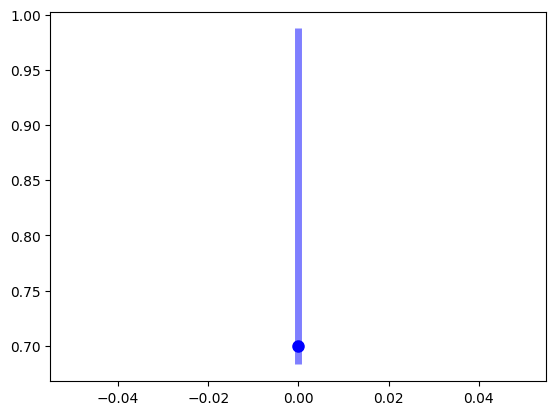

In [362]:
from scipy.stats import binomtest
data = binomtest((cm[0][0] + cm[1][1]), y_test.shape[0]).proportion_ci()
x = np.arange(scipy.stats.bernoulli.ppf(0.01, p),
              scipy.stats.bernoulli.ppf(0.99, p))
fig, ax = plt.subplots(1, 1)
ax.plot(x, scipy.stats.bernoulli.pmf(x, p), 'bo', ms=8, label='bernoulli pmf')
ax.vlines(x, data[0], data[1], colors='b', lw=5, alpha=0.5)
plt.show()

In [363]:
data = binomtest((cm[0][0] + cm[1][1]), y_test.shape[0]).proportion_ci()

resultados["Method 1: Regresion Logística"] = {
        "Modelo": 'RegLog',
        "Test accuracy": round(metricas[2],4),
        "Lower 95% CI": data[0],
        "Upper 95% CI": data[1],
    }

In [364]:
# MODEL_PATH = '../data/union/End/model_logreg.pkl'
# with open(MODEL_PATH, 'wb') as f:
#    pickle.dump(logreg, f) 

In [365]:
# !pip install -q -U lightgbm
# !pip install -q -U catboost
# !pip install scikit-plot

### Modelos de Clasificación: 
* XGBClassifier
* LGBMClassifier
* CatBoostClassifier
* Ajustes de hipérparámetros con GridSearchCV
* Transformación de datos numéricos con PolynomialFeatures
* Canalización de datos con Pipeline

In [366]:
num_columns = [ 'ccbd_diameter', 'sl2l_mean_length',
 'sl2l_diameter', 'ccbd_mean_length', 'sl2l_volume', 'tral_volume']

In [367]:
# vamos a usar polynomial features sobre las variables numéricas
poly = PolynomialFeatures()
# Las categorías "nue
# vas" que aparezcan se imputan con el valor de unknown_value
# o_encoder = OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=99999999)

In [368]:
pipeline = Pipeline([
    ("selector_num", ColumnTransformer(
        [
            ("poly", poly, num_columns)
        ], remainder="passthrough")
    ),
    ("classifier", CatBoostClassifier())
    ]
)

In [369]:
one_to_left = st.beta(10, 1) # Esta distribución nos dará valores entre 0 y 1 mayormente cercanos a 1

In [370]:
# este diccionario de parámetros lo vamos a usar tanto para XGBoost como para LightGBM
params = {  
    "classifier__n_estimators": st.randint(20,150), # n. de árboles.
    "classifier__max_depth": st.randint(3, 12),     # máxima profundiad del árbol
    "classifier__learning_rate": st.uniform(0.05, 0.4), # learning rate (xgb’s “eta”)
    "classifier__colsample_bytree": one_to_left, # ratio de la muestra de las columnas a la hora de construir el árbol
    "classifier__subsample": one_to_left,     # ratio de la muestra de las observaciones
    'classifier__reg_alpha': st.uniform(0.05,10),   # término de regularización L1
    "classifier__min_child_weight": st.uniform(1,20), # Suma mínima del peso de la instancia (hessiano) requerida en los hijos
}

In [371]:
other_params = {"selector_num__poly__degree": [1, 2, 3]}

In [372]:
search_space = [{"classifier": [XGBClassifier(n_jobs=3, eval_metric="logloss", use_label_encoder=False)], 
                 **params,
                 **other_params,
                "classifier__gamma": st.uniform(0, 10), # reducción mínima de la pérdida requerida para hacer un split
                },
                {"classifier": [LGBMClassifier(n_jobs=3, verbose=-1)],
                 **params,
                **other_params},
                {"classifier": [CatBoostClassifier(thread_count=3, verbose=False)],
                 **other_params,
                "classifier__n_estimators": st.randint(20,150), # n. de árboles.
                "classifier__max_depth": st.randint(3, 12),     # máxima profundiad del árbol
                "classifier__learning_rate": st.uniform(0.05, 0.4), # learning rate (xgb’s “eta”)
                "classifier__subsample": one_to_left,     # ratio de la muestra de las observaciones
                },
               {
                   "classifier": [LogisticRegression(max_iter=1000)],
                   "classifier__C": [10**x for x in range(-5, 3)],
               }]

In [373]:
model = RandomizedSearchCV(pipeline, search_space, n_iter=100, verbose=1, cv=3)
model.fit(X_train, y_train)

results = pd.DataFrame(model.cv_results_)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


In [374]:
results.columns

Index(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time',
       'param_classifier', 'param_classifier__learning_rate',
       'param_classifier__max_depth', 'param_classifier__n_estimators',
       'param_classifier__subsample', 'param_selector_num__poly__degree',
       'param_classifier__colsample_bytree', 'param_classifier__gamma',
       'param_classifier__min_child_weight', 'param_classifier__reg_alpha',
       'param_classifier__C', 'params', 'split0_test_score',
       'split1_test_score', 'split2_test_score', 'mean_test_score',
       'std_test_score', 'rank_test_score'],
      dtype='object')

In [375]:
model.best_score_

0.6969230769230769

In [376]:
model.best_params_

{'classifier': LGBMClassifier(colsample_bytree=0.983391988488723,
                learning_rate=0.1840750935591967, max_depth=5,
                min_child_weight=4.479093044845092, n_estimators=112, n_jobs=3,
                reg_alpha=5.296517868926972, subsample=0.7618839806948094,
                verbose=-1),
 'classifier__colsample_bytree': 0.983391988488723,
 'classifier__learning_rate': 0.1840750935591967,
 'classifier__max_depth': 5,
 'classifier__min_child_weight': 4.479093044845092,
 'classifier__n_estimators': 112,
 'classifier__reg_alpha': 5.296517868926972,
 'classifier__subsample': 0.7618839806948094,
 'selector_num__poly__degree': 1}

In [377]:
model.best_estimator_

Pipeline(steps=[('selector_num',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('poly',
                                                  PolynomialFeatures(degree=1),
                                                  ['ccbd_diameter',
                                                   'sl2l_mean_length',
                                                   'sl2l_diameter',
                                                   'ccbd_mean_length',
                                                   'sl2l_volume',
                                                   'tral_volume'])])),
                ('classifier',
                 LGBMClassifier(colsample_bytree=0.983391988488723,
                                learning_rate=0.1840750935591967, max_depth=5,
                                min_child_weight=4.479093044845092,
                                n_estimators=112, n_jobs=3,
                                reg_alpha=5.296517868926972,
                                subsample=0.7618839806948094, verbose=-1))])

In [378]:
X_test_ = pd.DataFrame(X_test, columns=[ 'ccbd_diameter', 'sl2l_mean_length',
 'sl2l_diameter', 'ccbd_mean_length','sl2l_volume', 'tral_volume','label'])

In [379]:
y_predicted = model.predict_proba(X_test_)

<Axes: title={'center': 'ROC Curves'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

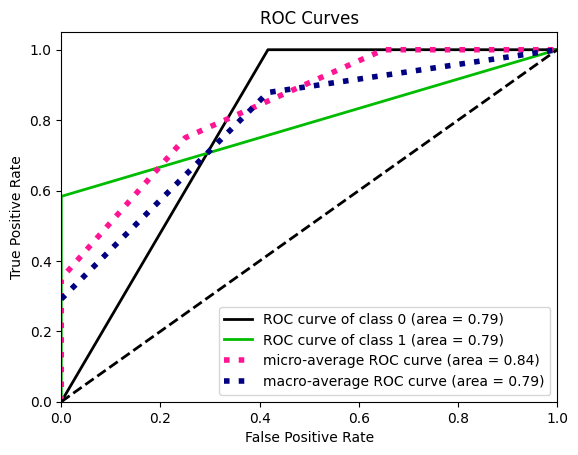

In [380]:
plot_roc(y_test, y_predicted)

In [381]:
roc_auc_score(y_test, y_predicted[:,1])

0.7916666666666667

In [382]:
print(classification_report(y_true=y_test,y_pred=model.predict(X_test_)))

              precision    recall  f1-score   support

           0       0.62      1.00      0.76         8
           1       1.00      0.58      0.74        12

    accuracy                           0.75        20
   macro avg       0.81      0.79      0.75        20
weighted avg       0.85      0.75      0.75        20



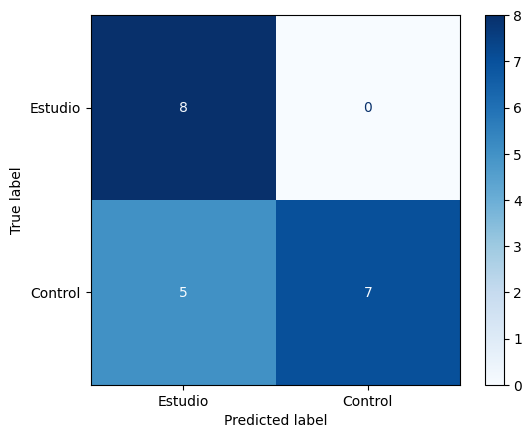

In [383]:
class_names = ['Estudio', 'Control']
ConfusionMatrixDisplay.from_estimator(model, X_test_, y_test, display_labels=class_names, cmap=plt.cm.Blues)
plt.show()

In [384]:
valor4 = model.predict(X_test).tolist()
valor3 = y_test.label.values.tolist()

In [385]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(valor3, valor4) 
metricas = balanced_accuracy(cm)
print('Matriz de confusion del modelo es:')
print(cm)
print('Sensibilidad del modelo es de: {}'.format(round(metricas[0],4)))  
print('Especificidad del modelo es de: {}'.format(round(metricas[1],4)))  
print('BA del modelo es de: {}'.format(round(metricas[2],4))) 

Matriz de confusion del modelo es:
[[8 0]
 [5 7]]
Sensibilidad del modelo es de: 1.0
Especificidad del modelo es de: 0.6154
BA del modelo es de: 0.8077


In [386]:
data = binomtest((cm[0][0] + cm[1][1]), y_test.shape[0]).proportion_ci()

resultados["Method 2: Modelo GV"] = {
        "Modelo": model.best_estimator_,
        "Test accuracy": round(metricas[2],4),
        "Lower 95% CI": data[0],
        "Upper 95% CI": data[1],
    }

In [387]:
# MODEL_PATH = '../data/union/End/model_LGBMClassifier.pkl'
# with open(MODEL_PATH, 'wb') as f:
#     pickle.dump(model.best_estimator_, f) 

In [388]:
model.best_estimator_

Pipeline(steps=[('selector_num',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('poly',
                                                  PolynomialFeatures(degree=1),
                                                  ['ccbd_diameter',
                                                   'sl2l_mean_length',
                                                   'sl2l_diameter',
                                                   'ccbd_mean_length',
                                                   'sl2l_volume',
                                                   'tral_volume'])])),
                ('classifier',
                 LGBMClassifier(colsample_bytree=0.983391988488723,
                                learning_rate=0.1840750935591967, max_depth=5,
                                min_child_weight=4.479093044845092,
                                n_estimators=112, n_jobs=3,
                                reg_alpha=5.296517868926972,
                                subsample=0.7618839806948094, verbose=-1))])

In [389]:
model.predict_proba

<bound method BaseSearchCV.predict_proba of RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('selector_num',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('poly',
                                                                               PolynomialFeatures(),
                                                                               ['ccbd_diameter',
                                                                                'sl2l_mean_length',
                                                                                'sl2l_diameter',
                                                                                'ccbd_mean_length',
                                                                                'sl2l_volume',
                                                                                'tral_volume'])])),
   

In [390]:
# !pip install -q -U ngboost

In [391]:
from ngboost import NGBClassifier
from ngboost.distns import k_categorical, Bernoulli
from ngboost.scores import LogScore
from math import sqrt

In [392]:
ngb_cat = NGBClassifier(Dist=Bernoulli, verbose=False) # tiene 2 estados
model2 = ngb_cat.fit(X_train, y_train) # Y should have only 3 values: {0,1,2}

In [393]:
ngb_cat.predict(X_test)[0:5]

array([0, 1, 0, 0, 1], dtype=int64)

In [394]:
ngb_cat.predict_proba(X_test)[0:5]

array([[7.15888345e-01, 2.84111655e-01],
       [1.20989792e-01, 8.79010208e-01],
       [8.60274409e-01, 1.39725591e-01],
       [9.99145536e-01, 8.54464032e-04],
       [2.29638708e-01, 7.70361292e-01]])

In [395]:
ngb_cat.pred_dist(X_test)[0:5].params

{'p0': array([0.71588834, 0.12098979, 0.86027441, 0.99914554, 0.22963871]),
 'p1': array([2.84111655e-01, 8.79010208e-01, 1.39725591e-01, 8.54464032e-04,
        7.70361292e-01])}

In [396]:
NGBClassifier(Dist=Bernoulli, Score=LogScore, verbose=True).fit(X_train, y_train)

[iter 0] loss=0.6931 val_loss=0.0000 scale=4.0000 norm=8.0000
[iter 100] loss=0.2034 val_loss=0.0000 scale=4.0000 norm=5.0753
[iter 200] loss=0.1390 val_loss=0.0000 scale=2.0000 norm=2.3745
[iter 300] loss=0.1203 val_loss=0.0000 scale=0.5000 norm=0.5811
[iter 400] loss=0.1111 val_loss=0.0000 scale=2.0000 norm=2.3005


NGBClassifier(random_state=RandomState(MT19937) at 0x2E27F6C8440)

In [397]:
preds = ngb_cat.predict(X_test)
score = roc_auc_score(y_test, preds)
print("ROC AUC Score: %f" % score)

ROC AUC Score: 0.791667


In [398]:
valor6 = ngb_cat.predict(X_test).tolist()
valor5 = y_test.label.values.tolist()

In [399]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(valor5, valor6) 
metricas = balanced_accuracy(cm)
print('Matriz de confusion del modelo es:')
print(cm)
print('Sensibilidad del modelo es de: {}'.format(round(metricas[0],4)))  
print('Especificidad del modelo es de: {}'.format(round(metricas[1],4)))  
print('BA del modelo es de: {}'.format(round(metricas[2],4))) 

Matriz de confusion del modelo es:
[[8 0]
 [5 7]]
Sensibilidad del modelo es de: 1.0
Especificidad del modelo es de: 0.6154
BA del modelo es de: 0.8077


In [400]:
print(classification_report(y_true=y_test,y_pred=ngb_cat.predict(X_test)))

              precision    recall  f1-score   support

           0       0.62      1.00      0.76         8
           1       1.00      0.58      0.74        12

    accuracy                           0.75        20
   macro avg       0.81      0.79      0.75        20
weighted avg       0.85      0.75      0.75        20



In [401]:
data = binomtest((cm[0][0] + cm[1][1]), y_test.shape[0]).proportion_ci()

resultados["Method 3: Modelo NGB"] = {
        "Modelo": 'NGB',
        "Test accuracy": round(metricas[2],4),
        "Lower 95% CI": data[0],
        "Upper 95% CI": data[1],
    }

In [402]:
# Check the results
'''
print('Desviación Estándar de los valores residuales')
print('RMSE: NGBoost', round(sqrt(mean_squared_error(y_test, valor6)),4))
print('RMSE: Model', round(sqrt(mean_squared_error(y_test,valor4)),4))
print('RMSE: LogRG', round(sqrt(mean_squared_error(y_test,valor2)),4))
'''

"\nprint('Desviación Estándar de los valores residuales')\nprint('RMSE: NGBoost', round(sqrt(mean_squared_error(y_test, valor6)),4))\nprint('RMSE: Model', round(sqrt(mean_squared_error(y_test,valor4)),4))\nprint('RMSE: LogRG', round(sqrt(mean_squared_error(y_test,valor2)),4))\n"

In [403]:
y_test.count()

label    20
dtype: int64

In [404]:
from statsmodels.stats.proportion import proportion_confint

In [405]:
y_test.label.loc[y_test.label == 0].count(), y_predicted[:,1].shape[0]

(8, 20)

In [406]:
lower, upper = proportion_confint(17, 20, 0.05)

print('lower=%.3f, upper=%.3f' % (lower, upper))

lower=0.694, upper=1.000


https://medium.com/@ranjitmaity95/confidence-intervals-in-machinelearning-b727d9dbdfcd

In [407]:
'''
import scipy.stats

confidence = 0.95  # Change to your desired confidence level
z_value = scipy.stats.norm.ppf((1 + confidence) / 2.0)
print(z_value)

import numpy as np

confidence = 0.95  # Change to your desired confidence level
z_value = scipy.stats.norm.ppf((1 + confidence) / 2.0)

acc_test = model.score(X_test, y_test)
ci_length = z_value * np.sqrt((acc_test * (1 - acc_test)) / y_test.shape[0])

ci_lower = acc_test - ci_length
ci_upper = acc_test + ci_length

print(ci_lower, ci_upper)
'''

'\nimport scipy.stats\n\nconfidence = 0.95  # Change to your desired confidence level\nz_value = scipy.stats.norm.ppf((1 + confidence) / 2.0)\nprint(z_value)\n\nimport numpy as np\n\nconfidence = 0.95  # Change to your desired confidence level\nz_value = scipy.stats.norm.ppf((1 + confidence) / 2.0)\n\nacc_test = model.score(X_test, y_test)\nci_length = z_value * np.sqrt((acc_test * (1 - acc_test)) / y_test.shape[0])\n\nci_lower = acc_test - ci_length\nci_upper = acc_test + ci_length\n\nprint(ci_lower, ci_upper)\n'

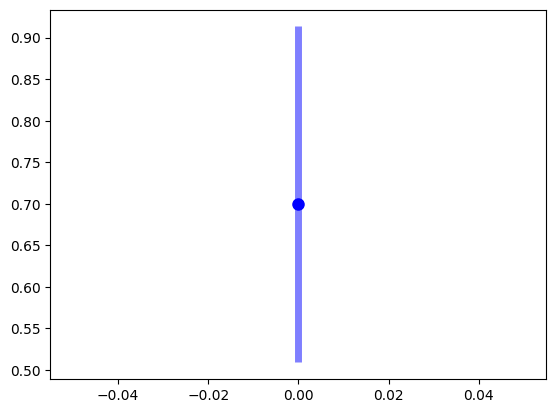

In [408]:
from scipy.stats import binomtest
data = binomtest((cm[0][0] + cm[1][1]), y_test.shape[0]).proportion_ci()
x = np.arange(scipy.stats.bernoulli.ppf(0.01, p),
              scipy.stats.bernoulli.ppf(0.99, p))
fig, ax = plt.subplots(1, 1)
ax.plot(x, scipy.stats.bernoulli.pmf(x, p), 'bo', ms=8, label='bernoulli pmf')
ax.vlines(x, data[0], data[1], colors='b', lw=5, alpha=0.5)
plt.show()

In [410]:
'''
model.score(X_test, y_test)
np.sqrt((acc_test * (1 - acc_test)))
ngb_cat.Dist
'''

'\nmodel.score(X_test, y_test)\nnp.sqrt((acc_test * (1 - acc_test)))\nngb_cat.Dist\n'

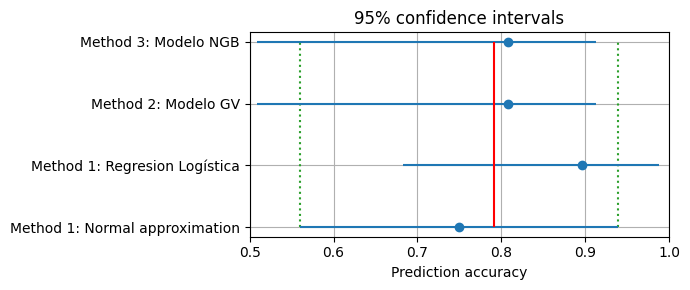

In [446]:
labels = list(resultados.keys())

means = np.array([resultados[k]["Test accuracy"] for k in labels])
lower_error = np.array([resultados[k]["Lower 95% CI"] for k in labels])
upper_error = np.array([resultados[k]["Upper 95% CI"] for k in labels])

asymmetric_error = [means - lower_error, upper_error - means]

fig, ax = plt.subplots(figsize=(7, 3))

ax.vlines(ci_lower, [0], 3, lw=1.5, linestyle="dotted", label="95% CI", color="C2")
ax.vlines(ci_upper, [0], 3, lw=1.5, linestyle="dotted", color="C2")

ax.errorbar(means, np.arange(len(means)), xerr=asymmetric_error, fmt="o")
ax.set_xlim([0.5, 1.0])
ax.set_yticks(np.arange(len(means)))
ax.set_yticklabels(labels)
ax.set_xlabel("Prediction accuracy")
ax.set_title("95% confidence intervals")

ax.vlines(score, [0], 3, lw=1.5, color="red", linestyle="-", label="True value")


plt.grid()
plt.tight_layout()
plt.show()

In [455]:
resultados["Method 1: Regresion Logística"], resultados["Method 2: Modelo GV"], resultados["Method 3: Modelo NGB"], 

({'Modelo': 'RegLog',
  'Test accuracy': 0.8958,
  'Lower 95% CI': 0.6830172859809209,
  'Upper 95% CI': 0.9876514728297041},
 {'Modelo': Pipeline(steps=[('selector_num',
                   ColumnTransformer(remainder='passthrough',
                                     transformers=[('poly',
                                                    PolynomialFeatures(degree=1),
                                                    ['ccbd_diameter',
                                                     'sl2l_mean_length',
                                                     'sl2l_diameter',
                                                     'ccbd_mean_length',
                                                     'sl2l_volume',
                                                     'tral_volume'])])),
                  ('classifier',
                   LGBMClassifier(colsample_bytree=0.983391988488723,
                                  learning_rate=0.1840750935591967, max_depth=5,
              

In [449]:
dframe = pd.DataFrame([key for key in resultados.keys()], columns=['Name'])

In [453]:
dframe

,Name
0,Method 1: Normal approximation
1,Method 1: Regresion Logística
2,Method 2: Modelo GV
3,Method 3: Modelo NGB


In [452]:
[resultados[k]["Test accuracy"] for k in labels]

[0.75, 0.8958, 0.8077, 0.8077]

In [459]:
result = binomtest(3, n=20, p=0.1, alternative='greater')

In [460]:
result.pvalue

0.32307319481053454